## 广告点击率预测
这个项目的主要的目的是通过给定的广告信息和用户信息来预测一个广告被点击与否。 如果广告有很大概率被点击就展示广告，如果概率低，就不展示。 因为如果广告没有被点击，对双方（广告主、平台）来讲都没有好处。所以预测这个概率非常重要，也是此项目的目标。

在这个项目中，需要完成的任务有：
- ``数据的读取和理解``: 把给定的.csv文件读入到内存，并通过pandas做数据方面的统计以及可视化来更深入地理解数据。
- ``特征构造``: 从原始特征中衍生出一些新的特征，这部分在机器学习领域也是很重要的工作。
- ``特征的转化``: 特征一般分为连续型(continuous)和类别型（categorical), 需要分别做不同的处理。
- ``特征选择``: 从已有的特征中选择合适的特征，这部分也是很多项目中必不可少的部分。 
- ``模型训练与评估``: 通过交叉验证方式来训练模型，这里需要涉及到网格搜索等技术。

### 1. 数据读取和理解
对于``.CSV``的文件，我们一般使用``pandas``工具来读取，读取之后的数据会存放在``dataframe``中。在此项目中，我们使用的是``kaggle``的一个竞赛数据，具体官网地址为：https://www.kaggle.com/c/avazu-ctr-prediction 。 训练和测试数据分别为``train.csv``和``test.csv``。 官网提供的数据比较大，压缩之后的已经达到1G以上，故我们对数据进行了采样。 采样的规则为：从``train.csv``文件中读取头``400000``个样本，并重命名为``train_subset.csv``。 之后在这个数据的基础上我们会进一步分为训练集和测试集。

### 1.1 数据的读取

In [1]:
# 导入基本的库，每个项目的必备
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

# 设置matplotlib的模式
%matplotlib inline

# 设置matplot的样式
import matplotlib
matplotlib.style.use('ggplot')

In [3]:
# 通过pandas读取.csv文件，并展示头几个样本。
data_df = pd.read_csv('train_subset.csv')
data_df.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.000009e+18,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15706,320,50,1722,0,35,-1,79
1,1.000017e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
2,1.000037e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
3,1.000064e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,100084,79
4,1.000068e+19,0,14102100,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,...,1,0,18993,320,50,2161,0,35,-1,157


> ``问题1（TODO）：`` 在上面的数据中有一个特征叫作``hour``, 是时间的特征，但这个值有些看不懂... 这部分需要通过pandas来做处理。把这个数转换成具体时间的格式。请把这个特征格式化成``%y%m%d%H``形式。格式化完之后请覆盖掉原来的特征。提示： 使用 ``pd.to_datetime``函数，然后指定需要格式化的特征和格式化的样式。 

In [5]:
# TODO 把hour特征格式化成 '%y%m%d%H'形式。
data_df['hour'] = pd.to_datetime(data_df['hour'], format='%y%m%d%H')
# 重新打印一下查看是否有改变
data_df.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.000009e+18,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15706,320,50,1722,0,35,-1,79
1,1.000017e+19,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
2,1.000037e+19,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
3,1.000064e+19,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,100084,79
4,1.000068e+19,0,2014-10-21,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,...,1,0,18993,320,50,2161,0,35,-1,157


In [6]:
# 由于特征个数比较多，有些特征被隐藏掉了（表示成了...)， 为了把所有特征全部看到，可以分两次来展示：
data_df.iloc[:, :12].head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id
0,1.000009e+18,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a
1,1.000017e+19,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a
2,1.000037e+19,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a
3,1.000064e+19,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a
4,1.000068e+19,0,2014-10-21,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,07d7df22,a99f214a


In [7]:
data_df.iloc[:, 12:].head()

,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,ddd2926e,44956a24,1,2,15706,320,50,1722,0,35,-1,79
1,96809ac8,711ee120,1,0,15704,320,50,1722,0,35,100084,79
2,b3cf8def,8a4875bd,1,0,15704,320,50,1722,0,35,100084,79
3,e8275b8f,6332421a,1,0,15706,320,50,1722,0,35,100084,79
4,9644d0bf,779d90c2,1,0,18993,320,50,2161,0,35,-1,157


从上述数据中，我们发现大量的特征为类别型特征，而且很多特征已经被编码成看不懂的字符串（这些都是为了不公开用户数据），但即便如此，我们也可以把它们直接看成是类别型特征（categorical featuer）。

In [11]:
# 查看一下每一个特征的类型以及是否存在null
data_df.isnull().sum()

id                  0
click               0
hour                0
C1                  0
banner_pos          0
site_id             0
site_domain         0
site_category       0
app_id              0
app_domain          0
app_category        0
device_id           0
device_ip           0
device_model        0
device_type         0
device_conn_type    0
C14                 0
C15                 0
C16                 0
C17                 0
C18                 0
C19                 0
C20                 0
C21                 0
dtype: int64

### 1.2 数据的理解

#### ``id``特征 ####
我们是否需要这个特征？ 应该如何判断？ 如果发现不需要此特征就可以从data_df中删掉了。
> ``问题2（TODO）`` 1. 请判断这个特征有没有价值  2. 如果没有价值就把它从data_df中删掉。

如果对于每一个样本，``id``都是不一样的，那显然是无用的特征。

In [12]:
# TODO： 删除id
data_df.drop(['id'], axis=1, inplace=True)
data_df.head()

,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,1,2,15706,320,50,1722,0,35,-1,79
1,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,1,0,15704,320,50,1722,0,35,100084,79
2,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,1,0,15704,320,50,1722,0,35,100084,79
3,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,1,0,15706,320,50,1722,0,35,100084,79
4,0,2014-10-21,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,07d7df22,...,1,0,18993,320,50,2161,0,35,-1,157


#### ``click``标签(label) ####
对标签分布的理解是必不可少的，因为这直接跟样本不平衡相关。
> ``问题3（TODO）``: 对于``data_df``, 请输出正样本和负样本各自的比例。

In [13]:
# TODO： 输出正样本的负样本各自的比例
clicked_rate = len(data_df[data_df['click']==0])/len(data_df)
non_clicked_rate = len(data_df[data_df['click']==1])/len(data_df)
print('未点广告的占比为：{}'.format(clicked_rate))
print('点击广告的占比为：{}'.format(non_clicked_rate))

未点广告的占比为：0.8341095852739632
点击广告的占比为：0.16589041472603683


通过上述的数据，可以很容易看出被点击的次数要远小于没有被点击的次数。所以这个数据是不平衡的数据。但这个不平衡还没有那么严重。其实不平衡严重时，负样本和正样本比例有可能1000：1， 甚至更悬殊。 由于样本的不平衡，使用准确率是不明智的，所以评估指标我们选用``F1-score``.  

#### ``hour``特征 ####
时间特征有可能对我们帮助，比如是否凌晨点击率要低于早上的，是否早上的要低于下午的？ 从直观上理解其实是有帮助的。 但由于在这个项目中，我们只提取了前40万个样本，有可能时间上的差别不大（我们要知道一个大的平台，仅仅1分钟就可以收集到数十万到几百万以上的样本）。 但是，不管怎样，打印一下``hour``特征相关的信息看看：

In [23]:
data_df.hour.describe()

count                  399999
unique                      3
top       2014-10-21 02:00:00
freq                   143551
first     2014-10-21 00:00:00
last      2014-10-21 02:00:00
Name: hour, dtype: object

其实从上述的结果中可以看到，时间的区间为10-21的00点到10-21的02点，也就是2个小时的间隔。所以在使用这个特征的时候，可以把小时的特征提取出来，因为日期都是一样的（这部分没价值）。 

#### ``banner_pos``特征 ####
这是广告投放的位置，从直观上来看对广告点击的结果影响比较大，所以做一下可视化的分析并更好地理解这个特征。首先来看一下``banner_pos``的取值范围。 

In [25]:
data_df['banner_pos'].unique()

array([0, 1, 4, 5, 2, 7])

从这个结果里可以看出，它的范围是0-7， 但中间不包含3和6， 有可能是我们的训练数据不全。 对于这些数据请不要理所当然地理解为它表示的是具体的位置信息，比如1代表最前面的位置... 因为我们也不知道它的编码规则是怎么样的。但不管怎样，我们可以通过可视化方式来大概了解一下每一个位置对点击率的影响。 

> ``问题4（TODO）``: 通过可视化方式来展示每一个位置上的样本总数以及其中被点击和没有被点击的样本个数。

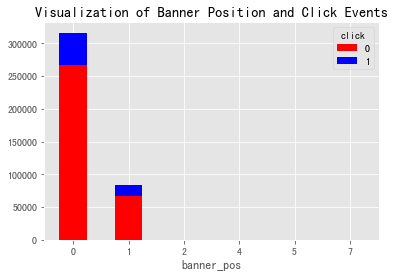

In [14]:
# TODO: 
x = sorted(list(data_df['banner_pos'].unique()))
y_0 = []
y_1 = []
for i in x:
    count_0 = len(data_df[(data_df['click']==0) & (data_df['banner_pos']==i)])
    count_1 = len(data_df[(data_df['click']==1) & (data_df['banner_pos']==i)])
    y_0.append(count_0)
    y_1.append(count_1)

plt.bar(range(len(x)), y_0, width=0.5, color='red', label=0)
plt.bar(range(len(x)), y_1, width=0.5, color='blue', label=1, bottom=y_0)
plt.title("Visualization of Banner Position and Click Events")
plt.xlabel("banner_pos")
plt.xticks(range(len(x)),x)
plt.legend(title='click')
plt.show()

> ``问题5（TODO)``： 生成完上面的图之后能感觉到这个特征还是蛮重要的，而且由于``banner_pos=2,4,5,7``的样本比较少，在图里不那么直观。所以我们就尝试打印一下一个表格。表格里的每一行针对于的是banner_pos具体的值，另外表格有两列，分别是false和true,  分别代表在某一个banner_pos的样本，有百分之多少的概率不被点击和被点击。 

In [15]:
# TODO: 
# 使用Decimal来保留小数点后六位
from decimal import Decimal
x = sorted(list(data_df['banner_pos'].unique()))
rate_0 = []
rate_1 = []
for i in x:
    length = len(data_df[data_df['banner_pos']==i])
    x = len(data_df[(data_df['click']==0) & (data_df['banner_pos']==i)])/length
    y = len(data_df[(data_df['click']==1) & (data_df['banner_pos']==i)])/length
    rate_0.append(Decimal(x).quantize(Decimal('0.000000')))
    rate_1.append(Decimal(y).quantize(Decimal('0.000000')))

data = {'0':rate_0,
        '1':rate_1
       }
click_banner_pos = pd.DataFrame(data,index=[0,1,2,4,5,7])
click_banner_pos.columns.name = 'click'
click_banner_pos.index.name = 'banner_pos'
click_banner_pos

click,0,1
banner_pos,,
0,0.842387,0.157613
1,0.802443,0.197557
2,0.901639,0.098361
4,0.866667,0.133333
5,0.876033,0.123967
7,0.909091,0.090909


#### ``site``相关特征 ####

In [77]:
site_features = ['site_id', 'site_domain', 'site_category']
data_df[site_features].describe()

,site_id,site_domain,site_category
count,399999,399999,399999
unique,1588,1464,21
top,85f751fd,c4e18dd6,50e219e0
freq,117380,122016,129039


In [78]:
app_features = ['app_id', 'app_domain', 'app_category']
data_df[app_features].describe()

,app_id,app_domain,app_category
count,399999,399999,399999
unique,1450,102,19
top,ecad2386,7801e8d9,07d7df22
freq,282619,298152,284444


> ``问题6（TODO）``:这里重点研究一下，``app_category``特征，看是否跟标签有比较强的关系。 为了理解这一点，对于每一种类型的``app_category``值，请画出``histogram``，展示每一种取值条件下样本被点击或者没有被点击的概率。

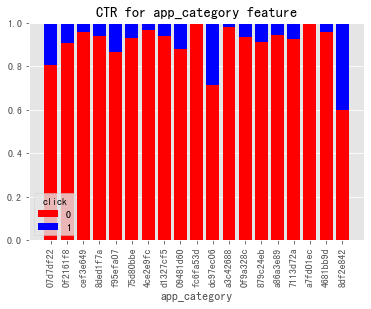

In [16]:
# TODO: 
import matplotlib.ticker as ticker
x = list(data_df['app_category'].unique())
y_0 = []
y_1 = []
for i in x:
    length = len(data_df[data_df['app_category']==i])
    rate_0 = len(data_df[(data_df['click']==0) & (data_df['app_category']==i)])/length
    rate_1 = len(data_df[(data_df['click']==1) & (data_df['app_category']==i)])/length
    y_0.append(rate_0)
    y_1.append(rate_1)

# 使用bar()来绘制堆叠柱状图
plt.bar(x, y_0, color='red', label=0)
plt.bar(x, y_1, color='blue', label=1, bottom=y_0)
plt.title("CTR for app_category feature")
plt.xlabel("app_category")
plt.legend(title='click')
plt.xticks(rotation=90)    # 设置横坐标标签旋转角度。
plt.show()

####  ``device``相关的特征 ####
查看跟device相关的特征信息

In [86]:
device_features = ['device_id', 'device_ip', 'device_model', 'device_type', 'device_conn_type']
data_df[device_features].astype('object').describe()

,device_id,device_ip,device_model,device_type,device_conn_type
count,399999,399999,399999,399999,399999
unique,33226,141109,3757,4,4
top,a99f214a,6b9769f2,8a4875bd,1,0
freq,337979,2747,26552,377567,358831


> ``问题7(TODO)``: 对于不同的``device_conn_type``, 画一个histogram，并表示在不同type的情况下被点击和没有被点击的概率。

[0.8291368360035782, 0.8709641412027348, 0.9178384893531539, 0.9661971830985916]
[0.1708631639964217, 0.12903585879726526, 0.08216151064684613, 0.03380281690140845]


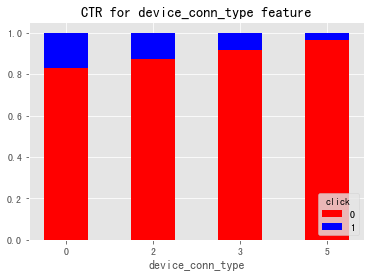

In [17]:
# TODO： 画出device_conn_type和CTR相关的histogram, 参考问题6的效果图。
# import matplotlib.ticker as ticker
x = sorted(list(data_df['device_conn_type'].unique()))
y_0 = []
y_1 = []
for i in x:
    length = len(data_df[data_df['device_conn_type']==i])
    rate_0 = len(data_df[(data_df['click']==0) & (data_df['device_conn_type']==i)])/length
    rate_1 = len(data_df[(data_df['click']==1) & (data_df['device_conn_type']==i)])/length
    y_0.append(rate_0)
    y_1.append(rate_1)

print(y_0)
print(y_1)
# 使用bar()来绘制堆叠柱状图
plt.bar(range(len(x)), y_0, width=0.5, color='red', label=0)
plt.bar(range(len(x)), y_1, width=0.5, color='blue', label=1, bottom=y_0)
plt.title("CTR for device_conn_type feature")
plt.xlabel("device_conn_type")
plt.xticks(range(len(x)), x)
plt.legend(title='click', loc='lower right')
# plt.xticks(rotation=90)    # 设置横坐标标签旋转角度。
plt.show()

#### ``C1, C14-C21`` 特征####
这些特征没有具体被标记到底是什么意思，有可能是涉及到公司的隐私。 当然，理解一个特征的含义其实挺重要的，但对于这个问题没办法，毕竟他们没有提供描述。但无论如何，也可以通过可视化分析去理解这些特征是否影响点击率。

In [5]:
c_features = ['C1', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']
data_df[c_features].astype('object').describe()

,C1,C14,C15,C16,C17,C18,C19,C20,C21
count,399999,399999,399999,399999,399999,399999,399999,399999,399999
unique,6,520,6,7,149,4,40,152,33
top,1005,21647,320,50,1722,0,35,-1,79
freq,376760,40254,380863,382421,125595,218396,192931,233501,125595


> ``问题8（TODO）``： 请画出C1和点击率之间的关系。

In [105]:
x = sorted(list(data_df['C1'].unique()))
print(x)

[1001, 1002, 1005, 1007, 1008, 1010]


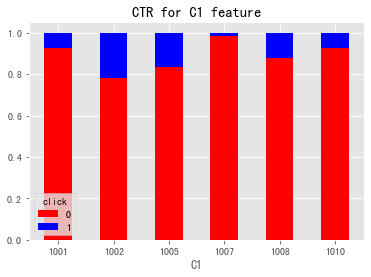

In [18]:
# TODO: 画如上所要求的图

x = sorted(list(data_df['C1'].unique()))
y_0 = []
y_1 = []
for i in x:
    length = len(data_df[data_df['C1']==i])
    rate_0 = len(data_df[(data_df['click']==0) & (data_df['C1']==i)])/length
    rate_1 = len(data_df[(data_df['click']==1) & (data_df['C1']==i)])/length
    y_0.append(rate_0)
    y_1.append(rate_1)

# 使用bar()来绘制堆叠柱状图
plt.bar(range(len(x)), y_0, width=0.5, color='red', label=0)
plt.bar(range(len(x)), y_1, width=0.5, color='blue', label=1, bottom=y_0)
plt.title("CTR for C1 feature")
plt.xlabel("C1")
plt.xticks(range(len(x)), x)
plt.legend(title='click')
# plt.xticks(rotation=90)    # 设置横坐标标签旋转角度。
plt.show()

### 2. 特征的构造
特征构造对于一个机器学习建模非常重要。它的意思就是基于原有给定的特征基础上构造一些新的特征。构造特征的方法有很多： 1. 在原有的特征基础上做一些转换从而提取特征 2. 不同特征之间利用常规的运算来构造更复杂的特征（比如有特征f1, f2, 则可以通过f1 * f2操作生成新的特征)。

首先，我们来看一下数据集里的``hour``字段.

In [20]:
a = data_df[data_df['hour']=='2014-10-21 00:00:00']['hour'][0]
print(a)

2014-10-21 00:00:00


In [21]:
b = data_df[data_df['hour']=='2014-10-21 01:00:00']['hour'][119006]
print(b)

2014-10-21 01:00:00


In [22]:
c = data_df[data_df['hour']=='2014-10-21 02:00:00']['hour'][256448]
print(type(c))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [23]:
# 利用loc合并条件的方式来替换
# data_df['hour'].loc[data_df['hour']==a] = 0
# data_df['hour'].loc[data_df['hour']==b] = 1
# data_df['hour'].loc[data_df['hour']==c] = 2
data_df.loc[data_df['hour']==a, 'hour'] = 0
data_df.loc[data_df['hour']==b, 'hour'] = 1
data_df.loc[data_df['hour']==c, 'hour'] = 2

In [24]:
data_df['hour'].unique()

array([0, 1, 2])

由于我们的数据只是做了部分采样，所以对于所有的样本日期是一致的。唯一不一样的是具体的时间。时间从10-21 00点到 10-21 02点，总共3个不同的时间段来记录。

> ``问题9（TODO）``: 把``hour``这个字段转换成离散型变量，分别是0，1，2。 也就是2014-10-21 00点对应到0， 2014-10-21 01点对应到1， 2014-10-21 02点对应到2. 并把原来的``hour``字段替换一下。

### 3. 特征转化
在上述数据中，存在着大量的类别型特征(categorical feature), 这部分的特征我们需要转换成独热编码的形式（one-hot encoding)。 比如”男”，“女”这个特征分别转换成(0, 1), (1, 0)这种形式。 

In [29]:
# 由于这两个特征的稀疏性，从特征库中去掉。 但如果计算资源允许，可以加入进来。 
data_df.drop('device_id', axis=1, inplace=True)
data_df.drop('device_ip', axis=1, inplace=True)
data_df.drop('device_model', axis=1, inplace=True)
data_df.drop('site_id', axis=1, inplace=True)
data_df.drop('site_domain', axis=1, inplace=True)
data_df.drop('app_id', axis=1, inplace=True)

In [30]:
# 输出数据的描述
data_df.astype('object').describe()

,click,hour,C1,banner_pos,site_category,app_domain,app_category,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
count,399999,399999,399999,399999,399999,399999,399999,399999,399999,399999,399999,399999,399999,399999,399999,399999,399999
unique,2,3,6,6,21,102,19,4,4,520,6,7,149,4,40,152,33
top,0,2,1005,0,50e219e0,7801e8d9,07d7df22,1,0,21647,320,50,1722,0,35,-1,79
freq,333643,143551,376760,316027,129039,298152,284444,377567,358831,40254,380863,382421,125595,218396,192931,233501,125595


> ``问题10（TODO）`` 数据中的每一个特征，其实都可以看作是类别型特征（离散型）， 所以我们接下来要对所有的特征做独热编码的转换。这个时候总特征的维度就 变成每一个特征独热编码长度之和。 （也就是表格里的unique的之和）。务必要删除原始特征，因为已经把它们转换成了新的独热编码的形式。 

In [ ]:
# # 将每一个特征变量进行独热编码

data_df_hour = data_df['hour'].apply(str).str.get_dummies().add_prefix('hour:')
data_df_C1 = data_df['C1'].apply(str).str.get_dummies().add_prefix('C1:')
data_df_banner_pos = data_df['banner_pos'].apply(str).str.get_dummies().add_prefix('banner_pos:')
data_df_site_category = data_df['site_category'].apply(str).str.get_dummies().add_prefix('site_category:')
data_df_app_domain = data_df['app_domain'].apply(str).str.get_dummies().add_prefix('app_domain:')
data_df_app_category = data_df['app_category'].apply(str).str.get_dummies().add_prefix('app_category:')
data_df_device_type = data_df['device_type'].apply(str).str.get_dummies().add_prefix('device_type:')
data_df_device_conn_type = data_df['device_conn_type'].apply(str).str.get_dummies().add_prefix('device_conn_type:')
data_df_C14 = data_df['C14'].apply(str).str.get_dummies().add_prefix('C14:')
data_df_C15 = data_df['C15'].apply(str).str.get_dummies().add_prefix('C15:')
data_df_C16 = data_df['C16'].apply(str).str.get_dummies().add_prefix('C16:')
data_df_C17 = data_df['C17'].apply(str).str.get_dummies().add_prefix('C17:')
data_df_C18 = data_df['C18'].apply(str).str.get_dummies().add_prefix('C18:')
data_df_C19 = data_df['C19'].apply(str).str.get_dummies().add_prefix('C19:')
data_df_C20 = data_df['C20'].apply(str).str.get_dummies().add_prefix('C20:')
data_df_C21 = data_df['C21'].apply(str).str.get_dummies().add_prefix('C21:')

In [81]:
# TODO: 合并成新的数据集并删除原始特征
data_df = pd.concat([data_df,data_df_hour,data_df_C1,data_df_banner_pos,data_df_site_category,data_df_app_domain,data_df_app_category,data_df_device_type,data_df_device_conn_type,data_df_C14,data_df_C15,data_df_C16,data_df_C17,data_df_C18,data_df_C19,data_df_C20,data_df_C21], axis=1)
data_df = data_df.drop(['hour','C1','banner_pos','site_category','app_domain','app_category','device_type','device_conn_type','C14','C15','C16','C17','C18','C19','C20','C21'], axis=1)

In [86]:
# 构造训练数据和测试数据
feature_names = np.array(data_df.columns[data_df.columns != 'click'].tolist())

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data_df[feature_names].values, 
    data_df['click'].values,
    test_size=0.2,
    random_state=42
)

In [87]:
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(319999, 1076) (80000, 1076) (319999,) (80000,)


### 4. 特征选择
由于转换成了独热编码的形式，你会发现数据的维度一下子变多了，从几十维编程了上千维。在这里，我们使用基于L1+逻辑回归的方法。

> ``问题11（TODO）``： 使用基于L1的方法，请参考https://scikit-learn.org/stable/modules/feature_selection.html （SelectFromModel部分）。 我们使用的模型是逻辑回归 + L1的正则。 我们都知道L1正则会产生稀疏解，相当于帮我们选出特征。具体的方法是： 对于每一种可能的C值（代表正则的强弱)做交叉验证，从中选择效果最好的C值， 而且对于这个C值，我们有对应的选出来的特征。 

In [89]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

params_c = np.logspace(-4, 1, 11)
# TODO: 循环每一个C值，计算交叉验证后的F1-SCORE， 最终选择最好的C值c_best， 然后选出针对这个c_best对应的特征。 务必要使用L1正则。
#       对于实现，有很多方法，自行选择合理的方法就可以了。 关键是包括以下模块：1. 逻辑回归   2. 交叉验证  3. L1正则  4. SelectFromModel
lr = LogisticRegression(penalty='l1')
parameters = {'C': params_c}
grid_search = GridSearchCV(lr, param_grid=parameters, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

# 求出c_best
c_best = grid_search.best_params_
print(c_best)

/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMe

/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMe

/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

{'C': 10.0}


In [93]:
c_best = c_best['C']

In [94]:
# 通过c_best值，重新在整个X_train里做训练，并选出特征。
lr_clf = LogisticRegression(penalty='l1', C=c_best)
lr_clf.fit(X_train, y_train) # 在整个训练数据重新训练

select_model = SelectFromModel(lr_clf, prefit=True)
selected_features = select_model.get_support()  # 被选出来的特征

# 重新构造feature_names
feature_names = feature_names[selected_features]

# 重新构造训练数据和测试数据
X_train = X_train[:, selected_features]
X_test = X_test[:, selected_features]

/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [95]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(319999, 812) (80000, 812) (319999,) (80000,)


### 5. 模型训练与评估
选择完特征之后，我们来构建模型并做训练。通过交叉验证来学习最好的超参数。在这里我们使用两种类型的模型，分别是逻辑回归+L2正则，以及决策树。 

### 5.1 使用逻辑回归模型
> ``问题12（TODO）``在我们选择特征的时候其实也用了逻辑回归，但要记住，选特征的时候用的是L1的正则。但是在真正来训练最终版本模型的时候我们通常都是使用L2正则。所以这里就按照这个逻辑来训练一个逻辑回归模型。需要注意的一点是：评价标准使用F1-SCORE, 包括在交叉验证阶段。 

In [96]:
from sklearn.metrics import classification_report  #  这个用来打印最终的结果，包括F1-SCORE

params_c = np.logspace(-5,2,15) # 也可以自行定义一个范围

# TODO: 实现逻辑回归 + L2正则， 利用GrisSearchCV

lr = LogisticRegression(penalty='l2')
grid_search = GridSearchCV(lr, param_grid={'C': params_c}, cv=5, scoring='f1')
model = grid_search.fit(X_train, y_train)

# 输出最好的参数 
print(model.best_params_)



/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMe

/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMe

/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

{'C': 100.0}


In [97]:
# TODO: 在测试数据上预测，并打印在测试集上的结果

predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.85      0.98      0.91     66743
           1       0.53      0.11      0.18     13257

   micro avg       0.84      0.84      0.84     80000
   macro avg       0.69      0.54      0.54     80000
weighted avg       0.79      0.84      0.79     80000



### 5.2 使用决策树模型
> ``问题13（TODO）：``在这里，我们使用决策树算法做分类。 决策树本身有很多超参数需要调节，所以调节决策树的复杂度要远高于逻辑回归模型。决策树的使用请参考: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [113]:
from sklearn.tree import DecisionTreeClassifier

# params_min_samples_split = np.linspace(5, 20, 4)  # 报了一个版本错误ValueError: min_samples_leaf must be at least 1 or in (0, 0.5], got 2.0
                                                    # 现在使用0~1之间的数字作为比例来设置参数。
# params_min_samples_split = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
params_min_samples_split = [0.3,0.7]
# params_min_samples_leaf = np.linspace(2, 10, 5)
params_min_samples_leaf = [0.2,0.4]
params_max_depth = np.linspace(4, 10, 4)
paramters = {'min_samples_split':params_min_samples_split,
             'min_samples_leaf':params_min_samples_leaf,
             'max_depth':params_max_depth}
# TODO: 构造决策树，并做交叉验证。 除了上面三个参数，其他参数用默认的。 
dt = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator=dt, param_grid=paramters, cv=5, scoring='f1')
model = grid_search.fit(X_train, y_train)

# 输出最好的参数 
print(model.best_params_)

/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/m

/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/m

/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/m

/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/m

/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/m

{'max_depth': 4.0, 'min_samples_leaf': 0.2, 'min_samples_split': 0.3}


In [114]:
# TODO: 在测试数据上预测，并打印在测试集上的结果

predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91     66743
           1       0.00      0.00      0.00     13257

   micro avg       0.83      0.83      0.83     80000
   macro avg       0.42      0.50      0.45     80000
weighted avg       0.70      0.83      0.76     80000



/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### 5.3 使用XGBoost做分类
还有一类算法叫做XGBoost, 这是目前工业界和各类比赛最常用的算法之一。 它是一种集成式的方法，相当于多位专家共同去决策，所以模型既稳定效果也不错。这个模型也需要单独安装，具体安装请见： https://pypi.org/project/xgboost/  在linux和mac os上安装起来比较简单，但windows上可能会有各种问题出现，如在windows上使用，请参考： https://xgboost.readthedocs.io/en/latest/build.html

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
# TODO: 训练XGBoost模型  提示： 使用XGBClassifier。 至于超参数，可以试着去看一下官方文档，然后多尝试尝试。 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

# no mood to tune parameters, used the default ones
clf = XGBClassifier()
clf.fit(X_train, y_train, eval_metric='auc', verbose=True, eval_set=[(X_val, y_val)], early_stopping_rounds=100)

# TODO: 在测试数据上预测，并打印在测试集上的结果

y_pred = clf.predict(X_test)
y_pro = clf.predict_proba(X_test)[:, 1]
print(classification_report(y_test, predictions))